<a href="https://colab.research.google.com/github/carlocamilloni/Structural-Bioinformatics/blob/main/Notebooks/t03_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Dynamics simulation with GROMACS

The aim of this experience is to run  Molecular Dynamics simulations of simple systems and analyze them, we will focus on water and alanine dipeptide.

The reference lectures are:

*   https://github.com/carlocamilloni/Structural-Bioinformatics/blob/main/Notes/02_StochasticMolecules.pdf
*   https://github.com/carlocamilloni/Structural-Bioinformatics/blob/main/Notes/03_MolecularDynamics.pdf



## Preliminary setup

In [67]:
# install gromacs requirements
!apt update -qq
!apt install -y cmake build-essential libfftw3-dev wget

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gromacs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.10.5  |       hbd8a1cb_0         152 KB  conda-forge
    certifi-2025.10.5          |     pyhd8ed1ab_0         156 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    fftw-3.3.10                |nompi_hf1063bd_110         2.0 MB  conda-forge
    gromacs-2025.3             |nompi_h26635d9_100        32.7 MB  conda-forge
    libgfortran-14.2.0         |  

In [ ]:
# install gromacs
!wget https://ftp.gromacs.org/gromacs/gromacs-2025.3.tar.gz
!tar -xzf gromacs-2025.3.tar.gz
%cd gromacs-2025.3
%mkdir build
%cd build
!cmake .. -DCMAKE_BUILD_TYPE=Release -DGMX_GPU=CUDA
!make -j4
!make install
!ln -s /usr/local/gromacs/bin/gmx /usr/bin/gmx

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


Make a new folder for this task using the menus on the left side: for example in /drive/MyDrive/Structural_Bioinformatics make a folder named Task3.

In [4]:
# set the path to your local task folder
local_path='/content/drive/MyDrive/Structural_Bioinformatics/Task3'
%cd {local_path}

/content/drive/MyDrive/Structural_Bioinformatics/Task3


In [20]:
# make a copy of the GitHub structural bioinformatics repository
%cd {local_path}
%cd ..
%rm -rf sb
!git clone https://github.com/carlocamilloni/Structural-Bioinformatics.git sb --depth 1
%cd {local_path}

/content/drive/MyDrive/Structural_Bioinformatics/Task3
/content/drive/MyDrive/Structural_Bioinformatics
Cloning into 'sb'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 81 (delta 17), reused 46 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 144.69 MiB | 13.50 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Updating files: 100% (68/68), done.
/content/drive/MyDrive/Structural_Bioinformatics/Task3


All GROMACS tools are modules of a binary named "gmx". To get help about any GROMACS module, you can invoke either of the following commands:

gmx help (module)

or

gmx (module) -h

where (module) is replaced by the actual name of the command you're trying to issue. A full list of GROMACS modules can be printed by

gmx help commands

###Units

Basic units in GROMACS are

Time: ps

Space: nm

Energy: kJ/mol


## Molecular Dynamics of Lysozyme in solution

Here you will setup a simulation for hen egg-white lysozyme, a widely study system in structural biology. Its crystal structure can be find on the PDB as 1AKI

### Initial setup

In [19]:
# Download the structure from the PDB
%cd {local_path}
!wget https://files.rcsb.org/view/1AKI.pdb

--2025-10-27 13:14:30--  https://files.rcsb.org/view/1AKI.pdb
Resolving files.rcsb.org (files.rcsb.org)... 13.249.141.37, 13.249.141.40, 13.249.141.118, ...
Connecting to files.rcsb.org (files.rcsb.org)|13.249.141.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘1AKI.pdb’

1AKI.pdb                [ <=>                ] 113.67K  --.-KB/s    in 0.06s   

2025-10-27 13:14:30 (1.77 MB/s) - ‘1AKI.pdb’ saved [116397]



In [20]:
# Remove structural waters
!grep -v HOH 1AKI.pdb > 1AKI_clean.pdb

At this point one has to select the force field and the water model to be used in the simulation and prepare what is called the topology of the system, that is a file describing all the interactions as they appear in our system of interest. In GROMACS this is done using `pdb2gmx` and selecting some options. Becasue it is not possible to select options in `colab` we will need to provide them as flags:

In [28]:
# here we use charmm27 as a force field and tip3p as the water model
# we do not set protonation states so that by default we use pH 7
!gmx pdb2gmx -f 1AKI_clean.pdb -o 1AKI_processed.gro -ignh -water tip3p -ff "charmm27"

             :-) GROMACS - gmx pdb2gmx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [31]:
# some new files have been created, in particular:
# topol.top is the TOPOLOGY file
# 1AKI_processed.gro is the initial structure in default GROMACS format
%ls

 0-em-steep.mdp           '#md.log.1#'               md-water.trr
 1AKI_clean.pdb           '#md.log.2#'              '#md-water.trr.1#'
 1AKI.pdb                  mdout.mdp                '#md-water.trr.2#'
 1AKI_processed.gro        md-water.cpt              md-water.xtc
'#1AKI_processed.gro.1#'   md-water.edr             '#md-water.xtc.1#'
 conf.gro                 '#md-water.edr.1#'        '#md-water.xtc.2#'
'#conf.gro.1#'            '#md-water.edr.2#'         npt-water.mdp
'#conf.gro.2#'             md-water.gro              posre.itp
'#conf.gro.3#'            '#md-water.gro.1#'        '#posre.itp.1#'
 confout.gro              '#md-water.gro.2#'         rdf_293.xvg
'#confout.gro.1#'          md-water.log              rdf.xvg
'#confout.gro.2#'         '#md-water.log.1#'         spc216.gro
 em.tpr                   '#md-water.log.2#'         topol.top
'#em.tpr.1#'               md-water-nobpc.xtc       '#topol.top.1#'
'#em.tpr.2#'              '#md-water-nobpc.xtc.1#'  '#topol.top.2

The following step is to place the structure in a BOX that should be large enough to avoid self-interactions of the molecule through the sides but small enough to maximise performances. We set the box using `editconf`.

In [32]:
# set a dodecahedron like box whose distance from the protein is at least 1.2 nm
!gmx editconf -f 1AKI_processed.gro -bt dodecahedron -d 1.2 -o 1AKI_box.gro

             :-) GROMACS - gmx editconf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff           

Then we can solvate the protein using `solvate`:

In [33]:
# here we use spc216.gro coordinates of the solvent that are equivalent to tip3p
!gmx solvate -cp 1AKI_box -cs spc216.gro -p topol.top -o 1AKI_solv.gro

             :-) GROMACS - gmx solvate, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

You should see from the log something like 8700 water molecule that have been added to the system.

Next step is to add salts, to do this we need to calculate eletrostatic interactions and so we need to process the topology and structure and generate a GROMACS MD simulation input file. This is done using `grompp` and a molecular dynamics paratemers `.mdp` file. The the resulting file `ions.tpr` is used with the `genion` tool.

In [42]:
# copy an .mdp file from the downloaded structural bioinformatics repository
%cp ../sb/Data/md/mdps/0-em-steep.mdp .
# prepare a gromacs MD file combining structure, topolgy and parameters
!gmx grompp -f 0-em-steep.mdp -c 1AKI_solv.gro -p topol.top -o ions.tpr -maxwarn 1
# add ions to neutralize the systems at a concentration of 100 mM
# this tool is also interactive and we give in input "12" that means we substitue solvent molecules with salt molecules
!echo -e "13\n" | gmx genion -s ions -conc 0.1 -neutral -p topol.top -o 1AKI_ions

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

From the log you should see that some Na and Cl atoms have been added to the system.

### Energy minimisation and starting conditions

Before starting an MD simulation the system needs to be in a low energy configuration to avoid too large forces that would made the simulation unstable. This is done preparing a gromacs input file that uses the `steepest descent` algorithm to minimize the energy:

In [43]:
%cd {local_path}
!gmx grompp -f 0-em-steep.mdp -c 1AKI_ions.gro -p topol.top -o em.tpr

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

and then running the simulation using `mdrun`:

In [45]:
!gmx mdrun -deffnm em -v

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

The simulation takes less than a minute and will stop once some criteria are meet.

In [46]:
# there are more files now including: em.gro the configuration after the energy minimization
%ls

 0-em-steep.mdp            index.ndx                 md-water.tpr
 1AKI_box.gro              ions.tpr                 '#md-water.tpr.1#'
 1AKI_clean.pdb           '#ions.tpr.1#'            '#md-water.tpr.2#'
 1AKI_ions.gro            '#ions.tpr.2#'             md-water.trr
 1AKI.pdb                 '#ions.tpr.3#'            '#md-water.trr.1#'
 1AKI_processed.gro       '#ions.tpr.4#'            '#md-water.trr.2#'
'#1AKI_processed.gro.1#'  '#ions.tpr.5#'             md-water.xtc
 1AKI_solv.gro            '#ions.tpr.6#'            '#md-water.xtc.1#'
 conf.gro                  md.log                   '#md-water.xtc.2#'
'#conf.gro.1#'            '#md.log.1#'               npt-water.mdp
'#conf.gro.2#'            '#md.log.2#'               posre.itp
'#conf.gro.3#'             mdout.mdp                '#posre.itp.1#'
 confout.gro               md-water.cpt              rdf_293.xvg
'#confout.gro.1#'          md-water.edr              rdf.xvg
'#confout.gro.2#'         '#md-water.edr.1#'        

Now we need to bring the system to the desired temperature and pressure, for this we run our first MD simulation but keeping the protein restraint to its starting configuration, while we let the water reach the correct temperature and density. The protein will also move and reach the correct temperature but avoiding to change its configuration too much.

In [13]:
%cd {local_path}
%cp ../sb/Data/md/mdps/3-pr-npt.mdp .

/content/drive/MyDrive/Structural_Bioinformatics/Task3


You can check the `mdp` file we are gonna use:

```
integrator               = md; we do MD
dt                       = 0.002 ; with a 0.002 ps time step
nsteps                   = 25000 ; for 25000x0.002 = 50 ps (this is too short for real cases)
ref_t                    = 298 ; at 27 C
ref_p                    = 1 ; and 1 bar
```

a more thorough explanation is available here: https://manual.gromacs.org/2025.3/user-guide/mdp-options.html





In [14]:
%ls
%cat 3-pr-npt.mdp

 3-pr-npt.mdp             relax.edr        relax_prev.cpt  '#relax.trr.2#'
 condacolab_install.log  '#relax.edr.1#'   relax.tpr        relax.xtc
 em.gro                  '#relax.edr.2#'  '#relax.tpr.1#'  '#relax.xtc.1#'
 mdout.mdp                relax.log       '#relax.tpr.2#'  '#relax.xtc.2#'
 posre.itp               '#relax.log.1#'   relax.trr        topol.top
 relax.cpt               '#relax.log.2#'  '#relax.trr.1#'
;
;	File 'mdout.mdp' was generated
;	By user: carlo (501)
;	On host: Carlos-MacBook-Pro-2.local
;	At date: Tue Apr 28 22:27:57 2015
;

; VARIOUS PREPROCESSING OPTIONS
; Preprocessor information: use cpp syntax.
; e.g.: -I/home/joe/doe -I/home/mary/roe
include                  = 
; e.g.: -DPOSRES -DFLEXIBLE (note these variable names are case sensitive)
define                   = -DPOSRES

; RUN CONTROL PARAMETERS
integrator               = md
; Start time and timestep in ps
tinit                    = 0
dt                       = 0.002
nsteps                   = 25000
; F

In [15]:
%cd {local_path}
!gmx grompp -f 3-pr-npt.mdp -c em.gro -r em.gro -p topol.top -o relax.tpr

/content/drive/MyDrive/Structural_Bioinformatics/Task3
                :-) GROMACS - gmx grompp, 2025.3-conda_forge (-:

Executable:   /usr/local/bin.AVX2_256/gmx
Data prefix:  /usr/local
Working dir:  /content/drive/MyDrive/Structural_Bioinformatics/Task3
Command line:
  gmx grompp -f 3-pr-npt.mdp -c em.gro -r em.gro -p topol.top -o relax.tpr

Ignoring obsolete mdp entry 'ns_type'
Setting the LD random seed to 2080365308

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to 1920660191

Velocities were tak

In [16]:
# ready to run it
# CONSIDER THAT IT WILL TAKE 20 MINUTES, be carefull because COLAB can disconnect and stop it
# if you leave your session unattended and the laptop goes to sleep
!gmx mdrun -deffnm relax -v

                :-) GROMACS - gmx mdrun, 2025.3-conda_forge (-:

Executable:   /usr/local/bin.AVX2_256/gmx
Data prefix:  /usr/local
Working dir:  /content/drive/MyDrive/Structural_Bioinformatics/Task3
Command line:
  gmx mdrun -deffnm relax -v


Back Off! I just backed up relax.log to ./#relax.log.3#
The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file relax.tpr, VERSION 2025.3-conda_forge (single precision)
Changing nstlist from 20 to 50, rlist from 1.026 to 1.105


Using 1 MPI thread
Using 2 OpenMP threads 


Back Off! I just backed up relax.xtc to ./#relax.xtc.3#

Back Off! I just backed up relax.trr to ./#relax.trr.3#

Back Off! I just backed up relax.edr to ./#relax.edr.3#
starting mdrun 'LYSOZYME in water'
25000 steps,     50.0 ps.
step 24900, remaining

Now the system is ready to be simulated for production.
In practice we cannot run long MD simulations using the COLAB free plan. The simulation we plan to run is only 200 ps long and still will take more than 1 hour. On a modern workstation with an optimised setup we should get around

In [21]:
%cd {local_path}
%cp ../sb/Data/md/mdps/5-npt.mdp .

/content/drive/MyDrive/Structural_Bioinformatics/Task3


In [22]:
!gmx grompp -f 5-npt.mdp -c relax.gro -p topol.top -o npt.tpr

                :-) GROMACS - gmx grompp, 2025.3-conda_forge (-:

Executable:   /usr/local/bin.AVX2_256/gmx
Data prefix:  /usr/local
Working dir:  /content/drive/MyDrive/Structural_Bioinformatics/Task3
Command line:
  gmx grompp -f 5-npt.mdp -c relax.gro -p topol.top -o npt.tpr

Ignoring obsolete mdp entry 'ns_type'
Setting the LD random seed to 1941906863

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -1124140549

Velocities were taken from a Maxwell distribution at 298 K
Analysing residue names:
T

In [23]:
#run it
# CONSIDER THAT IT WILL TAKE MORE THAN 60 MINUTES, be carefull because COLAB can disconnect and stop it
# if you leave your session unattended and the laptop goes to sleep
!gmx mdrun -deffnm npt -v

                :-) GROMACS - gmx mdrun, 2025.3-conda_forge (-:

Executable:   /usr/local/bin.AVX2_256/gmx
Data prefix:  /usr/local
Working dir:  /content/drive/MyDrive/Structural_Bioinformatics/Task3
Command line:
  gmx mdrun -deffnm npt -v

The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file npt.tpr, VERSION 2025.3-conda_forge (single precision)
Changing nstlist from 20 to 50, rlist from 1.026 to 1.105


Using 1 MPI thread
Using 2 OpenMP threads 

starting mdrun 'LYSOZYME in water'
100000 steps,    200.0 ps.
step 99900, remaining wall clock time:     3 s          
Writing final coordinates.
step 100000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)        (%)
       Time:     7993.417     3996.715      200.0
          

### Visualisation

Once the simulation is ended you should have few more files:

In [16]:
%ls

 0-em-steep.mdp    '#md.log.2#'              '#md-water.tpr.2#'
 conf.gro           mdout.mdp                 md-water.trr
'#conf.gro.1#'      md-water.cpt             '#md-water.trr.1#'
'#conf.gro.2#'      md-water.edr             '#md-water.trr.2#'
'#conf.gro.3#'     '#md-water.edr.1#'         md-water.xtc
 confout.gro       '#md-water.edr.2#'        '#md-water.xtc.1#'
'#confout.gro.1#'   md-water.gro             '#md-water.xtc.2#'
'#confout.gro.2#'  '#md-water.gro.1#'         npt-water.mdp
 em.tpr            '#md-water.gro.2#'         rdf_293.xvg
'#em.tpr.1#'        md-water.log              rdf.xvg
'#em.tpr.2#'       '#md-water.log.1#'         spc216.gro
 ener.edr          '#md-water.log.2#'         topol.top
'#ener.edr.1#'      md-water-nobpc.xtc       '#topol.top.1#'
'#ener.edr.2#'     '#md-water-nobpc.xtc.1#'  '#topol.top.2#'
 energy.xvg        '#md-water-nobpc.xtc.2#'  '#topol.top.3#'
 index.ndx          md-water_prev.cpt         traj.trr
 md.log             md-water.tpr       

*   npt.xtc: trajectory file generally including only solute
*   npt.trr: trajectory file including all atoms
*   npt.edr: energy file including all the information about energy
*   npt.gro: last frame of the trajectory
*   npt.cpt: checkpoint file for exact restart

You can look at the trajectory using VMD on your laptop, first load a `1AKI_box.gro` then from the menu FILE choose *Load Data Into Molecule* and select the `npt.xtc` file, this will add all the trajectory frames. You may see something like this:

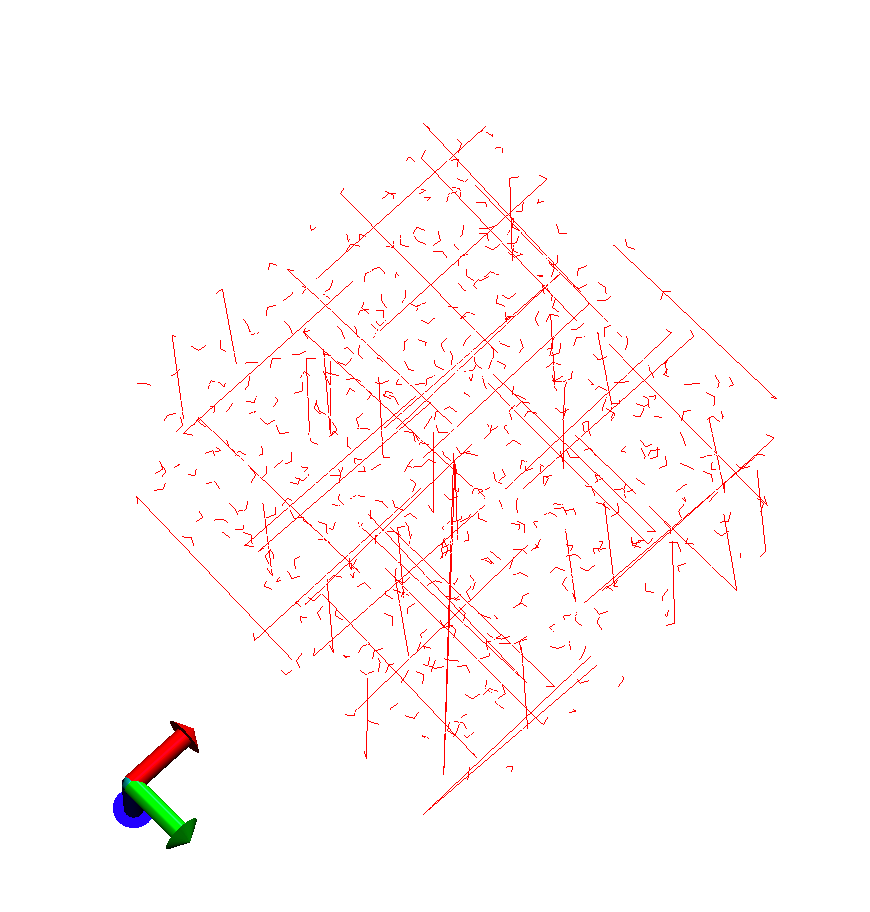

You remember the “PERIODIC BOUNDARY CONDITIONS”? A molecule be cut across the sides of the box. For the purpose of visualisation, we can remove this effect:

In [17]:
# here trjconv takes in input npt.xtc (-f) and the simulation ready file (-s npt.tpr)
# fix molecules to always be whole through covalent interactions (-pbc mol)
# write a corrected trajctory (-o npt-nopbc.xtc)
!echo -e "1\n" | gmx trjconv -f npt.xtc -s npt.tpr -pbc mol -o npt-nobpc.xtc

             :-) GROMACS - gmx trjconv, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Now you have one more file `npt-nopbc.xtc` that is the trajectory with molecules that are not broken across PBC. Close VMD and reopen it loading this new trajectory file. Now we can start to analyse the trajectory

### Analysis

1. Root Mean Square Deviation

2. Root Mean Square Fluctuations

3. Radius of Gyration

4. Secondary structures